In [2]:
# === 0. INSTALAR LIBRERÍAS ===
!pip install mido python-rtmidi networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/315.6 kB 12.8 MB/s eta 0:00:00


In [3]:

# === 1. IMPORTACIONES ===
from google.colab import files
import random, math
import networkx as nx
from mido import MidiFile, MidiTrack, Message
from collections import Counter, defaultdict
import matplotlib.pyplot as plt



#CODIGO EN AUTOMATICO

Por favor, sube el archivo MIDI (CÍCLICO) que servirá como molde de estilo.


Saving LA_VIRGEN_DE_LA_MACARENA.mid to LA_VIRGEN_DE_LA_MACARENA (2).mid
Archivo subido: LA_VIRGEN_DE_LA_MACARENA (2).mid
Correcto: La grafica ya contiene el ciclo E4 -> E4

--- Iniciando AG de Exploración (Fase 1) ---
Gen 0: Mejor fitness = 0.5977
Gen 20: Mejor fitness = 0.6193
Gen 40: Mejor fitness = 0.6172
Gen 60: Mejor fitness = 0.6203
Gen 80: Mejor fitness = 0.6238
Gen 100: Mejor fitness = 0.6183
Gen 120: Mejor fitness = 0.6217
Gen 140: Mejor fitness = 0.6225
Gen 160: Mejor fitness = 0.6191
Gen 180: Mejor fitness = 0.6207
Gen 200: Mejor fitness = 0.6232
Gen 220: Mejor fitness = 0.6203
Gen 240: Mejor fitness = 0.6203
Gen 260: Mejor fitness = 0.6216
Gen 280: Mejor fitness = 0.6217
Gen 300: Mejor fitness = 0.6253
Gen 320: Mejor fitness = 0.6178
Gen 340: Mejor fitness = 0.6174
Gen 360: Mejor fitness = 0.6253
Gen 380: Mejor fitness = 0.6245

--- Iniciando Recocido Simulado para optimizar pesos alfas ---
Temperatura 9.5000 - Mejor energía: 0.7141
Temperatura 9.0250 - Mejor energía: 0.714

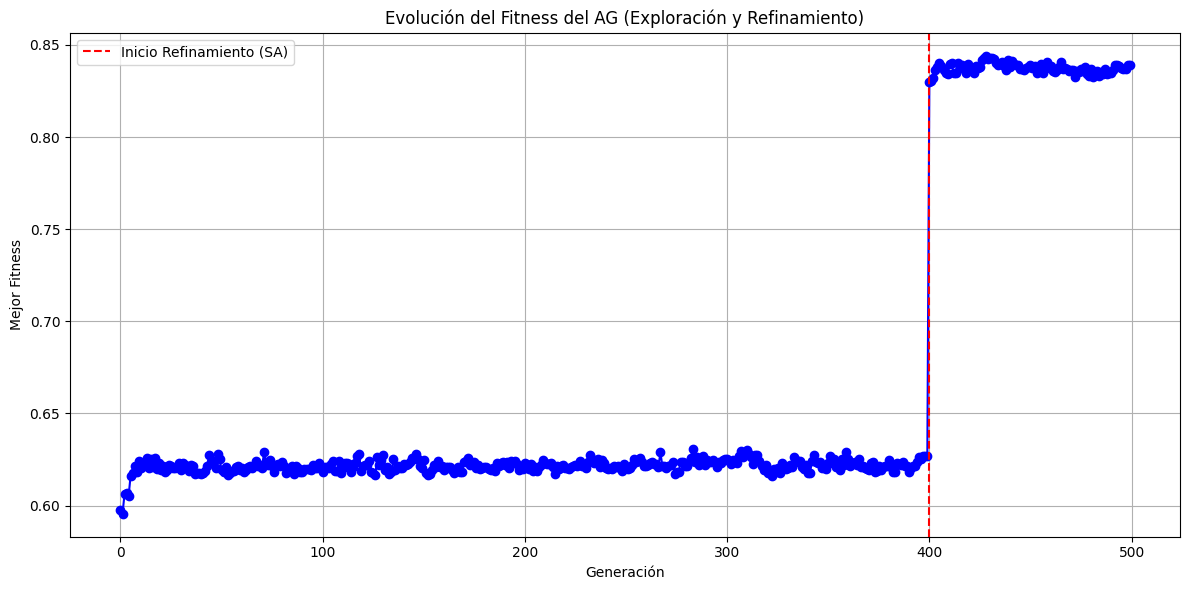

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Archivo MIDI generado y guardado: melodia_optimizada_final.mid


In [6]:

# ==============================================================================
# 2. SUBIR ARCHIVO MIDI
# ==============================================================================
print("Por favor, sube el archivo MIDI (CÍCLICO) que servirá como molde de estilo.")
uploaded = files.upload()
if not uploaded:
    print("No se subió ningún archivo. Terminando la ejecución.")
    exit()
nombre_archivo = list(uploaded.keys())[0]
print("Archivo subido:", nombre_archivo)

# ==============================================================================
# 3. CONVERSIÓN ENTRE NOTAS Y NÚMEROS MIDI
# ==============================================================================
clase_de_tonos = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def nombre_nota(n):
    return clase_de_tonos[n % 12]

def nombre_nota_completo(pitch_number):
    nota = clase_de_tonos[pitch_number % 12]
    octava = (pitch_number // 12) - 1
    return f"{nota}{octava}"

def nota_a_num_midi(nota_str):
    try:
        if nota_str[1] == '#':
            tono = nota_str[:2]
            octava = int(nota_str[2:])
        else:
            tono = nota_str[0]
            octava = int(nota_str[1:])
        return clase_de_tonos.index(tono) + (octava + 1) * 12
    except (ValueError, IndexError, AttributeError):
        return None

def num_midi_a_nota(n):
    return nombre_nota_completo(n)

# ==============================================================================
# 4. CREAR GRAFICA DESDE MIDI
# ==============================================================================
def grafica_midi(ruta_midi):
    mid = MidiFile(ruta_midi)
    notas = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notas.append(msg.note)
    G = nx.DiGraph()
    for i in range(len(notas)-1):
        G.add_edge(nombre_nota_completo(notas[i]), nombre_nota_completo(notas[i+1]))
    return notas, G

notas_midi, G = grafica_midi(nombre_archivo)
longitud_melodia = len(notas_midi)

# --- VERIFICACIÓN DE CICLO ---
if len(notas_midi) > 1:
    nota_final = nombre_nota_completo(notas_midi[-1])
    nota_inicial = nombre_nota_completo(notas_midi[0])
    if not G.has_edge(nota_final, nota_inicial):
        G.add_edge(nota_final, nota_inicial)
        print(f"Aviso: Se reforzó la conexión cíclica en grafica: {nota_final} -> {nota_inicial}")
    else:
        print(f"Correcto: La grafica ya contiene el ciclo {nota_final} -> {nota_inicial}")

# ==============================================================================
# 5. CAMINO ALEATORIO EN GRAFICA
# ==============================================================================
def camino_aleatorio(G, steps=5, start_node=None):
    if len(G.nodes) == 0: return []
    current_node = random.choice(list(G.nodes)) if start_node is None else start_node
    walk = [current_node]
    while len(walk) < steps:
        vecinos = list(G.successors(current_node))
        if not vecinos:
            # Si es cíclico esto no pasa, pero por seguridad elegimos al azar
            current_node = random.choice(list(G.nodes))
        else:
            current_node = random.choice(vecinos)
        walk.append(current_node)
    return walk

# ==============================================================================
# 6. FUNCIONES DE FITNESS
# ==============================================================================
def f1_fluidez_intervalar(melodia, I_max=12):
    N = len(melodia)
    if N < 2: return 0
    intervalos = [abs(melodia[i+1] - melodia[i]) for i in range(N - 1)]
    alpha = sum(intervalos) / (N - 1)
    return 1 - (min(alpha, I_max) / I_max)

def f2_coherencia_tonal(melodia, escala_referencia):
    if not melodia: return 0
    notas_en_escala = [n for n in melodia if nombre_nota(n) in escala_referencia]
    return len(notas_en_escala) / len(melodia)

def f3_rango_melodico(melodia, R_opt=24):
    if not melodia or len(melodia) < 2: return 1
    rango = max(melodia) - min(melodia)
    return 1 - (min(rango, R_opt) / R_opt)

def f4_unidad_motivica(melodia, k=3):
    N = len(melodia)
    if N < k: return 0
    subsecuencias = [tuple(melodia[i:i+k]) for i in range(N - k + 1)]
    contador = defaultdict(int)
    for subseq in subsecuencias:
        contador[subseq] += 1
    M_rep = sum(1 for count in contador.values() if count >= 2)
    M = len(subsecuencias)
    return M_rep / M if M > 0 else 0

def f5_similitud_melodica(melodia_generada, melodia_objetivo):
    N = min(len(melodia_generada), len(melodia_objetivo))
    if N == 0: return 0
    diferencia_total = sum(abs(melodia_generada[i] - melodia_objetivo[i]) for i in range(N))
    max_dif = N * 12
    return 1 - (diferencia_total / max_dif) if max_dif > 0 else 0

def fitness_total(melodia, escala_referencia, alfas, melodia_objetivo, I_max=12, R_opt=24, k=3):
    f1 = f1_fluidez_intervalar(melodia, I_max)
    f2 = f2_coherencia_tonal(melodia, escala_referencia)
    f3 = f3_rango_melodico(melodia, R_opt)
    f4 = f4_unidad_motivica(melodia, k)
    f5 = f5_similitud_melodica(melodia, melodia_objetivo)
    return (alfas[0]*f1 + alfas[1]*f2 + alfas[2]*f3 + alfas[3]*f4 + alfas[4]*f5)

# ==============================================================================
# 7. ESTRUCTURAS DEL ALGORITMO GENÉTICO
# ==============================================================================
class Individual:
    def __init__(self, genotype):
        self.genotype = genotype
        self.fitness = 0

def create_individual_from_graph(G, length):
    camino = camino_aleatorio(G, steps=length)
    notas_midi = [nota_a_num_midi(n) for n in camino if nota_a_num_midi(n) is not None]
    if len(notas_midi) < 2:
        # Fallback básico si falla la creación
        return Individual([notas_midi[0]]*length if notas_midi else [60]*length)
    return Individual(notas_midi)

def evaluate(population, fitness_fn):
    for ind in population:
        if ind.genotype:
            ind.fitness = fitness_fn(ind.genotype)
    population.sort(key=lambda ind: ind.fitness, reverse=True)

def rank_selection(population, K=3.0):
    size = len(population)
    ranks = [i / size for i in range(size)]
    expected = [K * (1 - r) ** (K - 1) for r in ranks]
    int_parts = list(map(math.floor, expected))
    frac_parts = [e - i for e, i in zip(expected, int_parts)]
    extra = random.choices(range(size), weights=frac_parts, k=size - sum(int_parts))
    clones = [Individual(population[i].genotype[:]) for i in range(size) for _ in range(int_parts[i] + extra.count(i))]
    return clones

def uniform_crossover(p1, p2, prob=0.5):
    min_len = min(len(p1.genotype), len(p2.genotype))
    for i in range(min_len):
        if random.random() < prob:
            p1.genotype[i], p2.genotype[i] = p2.genotype[i], p1.genotype[i]

def mutate_con_grafo(ind, G, rate=0.10):
    """Muta usando sucesores válidos. No usa notas de seguridad fijas."""
    nodes_list = list(G.nodes) # Lista de respaldo

    for i in range(len(ind.genotype) - 1):
        if random.random() < rate:
            nota_actual = num_midi_a_nota(ind.genotype[i])

            sucesores = []
            if nota_actual in G:
                sucesores = list(G.successors(nota_actual))

            if sucesores:
                nueva_nota_str = random.choice(sucesores)
                nueva_nota_midi = nota_a_num_midi(nueva_nota_str)
                if nueva_nota_midi is not None:
                    ind.genotype[i+1] = nueva_nota_midi
            else:
                if nodes_list:
                    random_node = random.choice(nodes_list)
                    midi_val = nota_a_num_midi(random_node)
                    if midi_val: ind.genotype[i+1] = midi_val
def repair_genotype(genotype, G):

    nodes_list = list(G.nodes)

    for i in range(len(genotype) - 1):
        nota_actual_midi = genotype[i]
        nota_sucesora_midi = genotype[i+1]

        nota_actual_str = num_midi_a_nota(nota_actual_midi)
        nota_sucesora_str = num_midi_a_nota(nota_sucesora_midi)

        is_invalid = False

        if nota_actual_str not in G.nodes:
            is_invalid = True
        elif not G.has_edge(nota_actual_str, nota_sucesora_str):
            is_invalid = True

        if is_invalid:
            valid_successors = []
            if nota_actual_str in G.nodes:
                valid_successors = list(G.successors(nota_actual_str))

            if valid_successors:
                # Reparación ideal: elegir un camino válido de grafica
                new_successor_str = random.choice(valid_successors)
                new_successor_midi = nota_a_num_midi(new_successor_str)
                if new_successor_midi is not None:
                    genotype[i+1] = new_successor_midi
            else:
                if nodes_list:
                    random_node = random.choice(nodes_list)
                    midi_val = nota_a_num_midi(random_node)
                    if midi_val: genotype[i+1] = midi_val

    return genotype

def repair_population(population, G):
    for ind in population:
        ind.genotype = repair_genotype(ind.genotype, G)

# ==============================================================================
# 9. RECOSIDO SIMULADO (SA) PARA BUSCAR ALFAS
# ==============================================================================
def energia(alfas, population, escala_referencia, notas_midi):
    fitnesses = []
    for ind in population:
        if ind.genotype:
            f = fitness_total(ind.genotype, escala_referencia, alfas, notas_midi)
            fitnesses.append(f)
    if not fitnesses: return 0
    max_fit = max(fitnesses)
    penalizacion = 0
    for a in alfas:
        if a > 0.7: penalizacion += (a - 0.7) ** 2 * 10
        if a < 0.1: penalizacion += (0.1 - a) ** 2 * 10
    return -(max_fit) + penalizacion

def normalizar_alfas(alfas):
    s = sum(alfas)
    if s == 0: return [1/len(alfas)]*len(alfas)
    return [a/s for a in alfas]

def vecino_alfas(alfas):
    vecino = [min(max(a + random.uniform(-0.05, 0.05), 0), 1) for a in alfas]
    return normalizar_alfas(vecino)

def simulated_annealing(population, escala_referencia, notas_midi,
                        T_ini=10, T_fin=0.01, alpha=0.95, iter_per_temp=50):
    alfas = normalizar_alfas([random.random() for _ in range(5)])
    mejor_alfas = alfas
    mejor_energia = energia(alfas, population, escala_referencia, notas_midi)
    T = T_ini

    while T > T_fin:
        for _ in range(iter_per_temp):
            vecino = vecino_alfas(alfas)
            e_vecino = energia(vecino, population, escala_referencia, notas_midi)
            delta = e_vecino - mejor_energia
            if delta < 0 or random.random() < math.exp(-delta / T):
                alfas = vecino
                if e_vecino < mejor_energia:
                    mejor_energia = e_vecino
                    mejor_alfas = vecino
        T *= alpha
        print(f"Temperatura {T:.4f} - Mejor energía: {-mejor_energia:.4f}")
    return mejor_alfas

# ==============================================================================
# 10. EJECUTAR AG Y OPTIMIZAR ALFAS
# ==============================================================================
clases = [nombre_nota(n) for n in notas_midi]
escala_referencia = [nota for nota, _ in Counter(clases).most_common(7)]
melodia_objetivo = notas_midi

# PARÁMETROS AG
population_size = 250
generations_inicial = 400

# AG FASE 1: Exploración
alfas_inicial = [0.2]*5
fitness_fn_inicial = lambda m: fitness_total(m, escala_referencia, alfas_inicial, notas_midi)

population = [create_individual_from_graph(G, longitud_melodia) for _ in range(population_size)]
historial_fitness = []

print("\n--- Iniciando AG de Exploración (Fase 1) ---")
for gen in range(generations_inicial):
    evaluate(population, fitness_fn_inicial)
    historial_fitness.append(population[0].fitness)
    if gen % 20 == 0:
        print(f"Gen {gen}: Mejor fitness = {population[0].fitness:.4f}")

    population = rank_selection(population)
    for i in range(0, len(population), 2):
        if i + 1 < len(population):
            uniform_crossover(population[i], population[i+1], prob=0.8)

    repair_population(population, G)

    for ind in population:
        mutate_con_grafo(ind, G, rate=0.08)

    repair_population(population, G)

# SA: Optimización de Pesos
print("\n--- Iniciando Recocido Simulado para optimizar pesos alfas ---")
mejores_alfas = simulated_annealing(population, escala_referencia, notas_midi)
print("Parámetros óptimos encontrados:", mejores_alfas)

# ==============================================================================
# 11. FASE DE REFINAMIENTO Y EXPORTACIÓN
# ==============================================================================
fitness_fn_final = lambda m: fitness_total(
    m, escala_referencia, mejores_alfas, notas_midi
)

generaciones_refinamiento = 100
print(f"\n--- Iniciando AG de Refinamiento (Fase 2, {generaciones_refinamiento} generaciones) ---")

for gen in range(generaciones_refinamiento):
    evaluate(population, fitness_fn_final)
    historial_fitness.append(population[0].fitness)

    if gen % 20 == 0:
        print(f"Refinamiento Gen {gen}: Mejor fitness = {population[0].fitness:.4f}")

    population = rank_selection(population)
    for i in range(0, len(population), 2):
        if i + 1 < len(population):
            uniform_crossover(population[i], population[i+1], prob=0.8)

    repair_population(population, G)

    for ind in population:
        mutate_con_grafo(ind, G, rate=0.08)

    repair_population(population, G)

evaluate(population, fitness_fn_final)
mejor_melodia_final = population[0]

print(f"\n¡Refinamiento Completado! El fitness final más alto es: {mejor_melodia_final.fitness:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(historial_fitness, marker='o', linestyle='-', color='blue')
plt.title('Evolución del Fitness del AG (Exploración y Refinamiento)')
plt.xlabel('Generación')
plt.ylabel('Mejor Fitness')
plt.grid(True)
plt.axvline(x=generations_inicial, color='red', linestyle='--', label='Inicio Refinamiento (SA)')
plt.legend()
plt.tight_layout()
plt.show()

output_mid_final = MidiFile()
melody_track_final = MidiTrack()
output_mid_final.tracks.append(melody_track_final)

duracion = 480

for note in mejor_melodia_final.genotype:
    melody_track_final.append(Message('note_on', note=note, velocity=64, time=0, channel=0))
    melody_track_final.append(Message('note_off', note=note, velocity=64, time=duracion, channel=0))

nombre_salida_final = "melodia_optimizada_final.mid"
output_mid_final.save(nombre_salida_final)
files.download(nombre_salida_final)
print(f"\nArchivo MIDI generado y guardado: {nombre_salida_final}")

#CODIGO CON PESOS FIJOS Y SIN (RS)

Por favor, sube el archivo MIDI (Cíclico) que servirá como molde de estilo.


Saving LA_VIRGEN_DE_LA_MACARENA.mid to LA_VIRGEN_DE_LA_MACARENA (3).mid
Archivo subido: LA_VIRGEN_DE_LA_MACARENA (3).mid
 El ciclo ya existía: E4 -> E4

--- Iniciando AG de Evolución Continua (500 generaciones) ---
Pesos de Fitness Fijos (Alpha): [0.05, 0.4, 0.05, 0.1, 0.4]
Gen 0: Mejor fitness = 0.7281
Gen 20: Mejor fitness = 0.7645
Gen 40: Mejor fitness = 0.7647
Gen 60: Mejor fitness = 0.7687
Gen 80: Mejor fitness = 0.7687
Gen 100: Mejor fitness = 0.7751
Gen 120: Mejor fitness = 0.7672
Gen 140: Mejor fitness = 0.7641
Gen 160: Mejor fitness = 0.7648
Gen 180: Mejor fitness = 0.7665
Gen 200: Mejor fitness = 0.7652
Gen 220: Mejor fitness = 0.7686
Gen 240: Mejor fitness = 0.7712
Gen 260: Mejor fitness = 0.7660
Gen 280: Mejor fitness = 0.7675
Gen 300: Mejor fitness = 0.7706
Gen 320: Mejor fitness = 0.7713
Gen 340: Mejor fitness = 0.7701
Gen 360: Mejor fitness = 0.7636
Gen 380: Mejor fitness = 0.7721
Gen 400: Mejor fitness = 0.7716
Gen 420: Mejor fitness = 0.7700
Gen 440: Mejor fitness = 0.

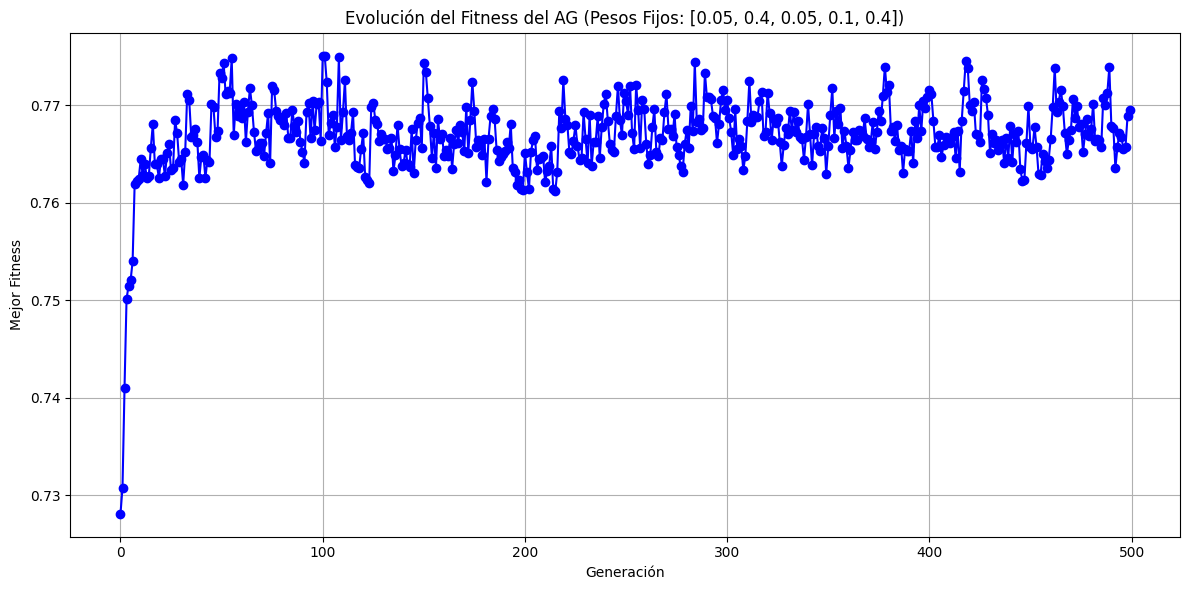

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Archivo MIDI generado y guardado: melodia_fija_manual.mid


In [8]:
# ==============================================================================
# 2. SUBIR ARCHIVO MIDI
# ==============================================================================
print("Por favor, sube el archivo MIDI (Cíclico) que servirá como molde de estilo.")
uploaded = files.upload()
if not uploaded:
    print("No se subió ningún archivo. Terminando la ejecución.")
    exit()
nombre_archivo = list(uploaded.keys())[0]
print("Archivo subido:", nombre_archivo)

# ==============================================================================
# 3. CONVERSIÓN ENTRE NOTAS Y NÚMEROS MIDI
# ==============================================================================
clase_de_tonos = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def nombre_nota(n):
    return clase_de_tonos[n % 12]

def nombre_nota_completo(pitch_number):
    nota = clase_de_tonos[pitch_number % 12]
    octava = (pitch_number // 12) - 1
    return f"{nota}{octava}"

def nota_a_num_midi(nota_str):
    try:
        if nota_str[1] == '#':
            tono = nota_str[:2]
            octava = int(nota_str[2:])
        else:
            tono = nota_str[0]
            octava = int(nota_str[1:])
        return clase_de_tonos.index(tono) + (octava + 1) * 12
    except (ValueError, IndexError, AttributeError):
        return None

def num_midi_a_nota(n):
    return nombre_nota_completo(n)

# ==============================================================================
# 4. CREAR GRAFICA DESDE MIDI
# ==============================================================================
def grafica_midi(ruta_midi):
    mid = MidiFile(ruta_midi)
    notas = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notas.append(msg.note)
    G = nx.DiGraph()
    for i in range(len(notas)-1):
        G.add_edge(nombre_nota_completo(notas[i]), nombre_nota_completo(notas[i+1]))
    return notas, G

notas_midi, G = grafica_midi(nombre_archivo)
longitud_melodia = len(notas_midi)

# --- 1: ASEGURAR CICLO ---
# Conecta la última nota con la primera para evitar callejones sin salida
if len(notas_midi) > 1:
    nota_final = nombre_nota_completo(notas_midi[-1])
    nota_inicial = nombre_nota_completo(notas_midi[0])
    if not G.has_edge(nota_final, nota_inicial):
        G.add_edge(nota_final, nota_inicial)
        print(f" Ciclo asegurado: Conectado {nota_final} -> {nota_inicial}")
    else:
        print(f" El ciclo ya existía: {nota_final} -> {nota_inicial}")

# ==============================================================================
# 5. CAMINO ALEATORIO EN GRAFICA
# ==============================================================================
def camino_aleatorio(G, steps=5, start_node=None):
    if len(G.nodes) == 0: return []
    current_node = random.choice(list(G.nodes)) if start_node is None else start_node
    walk = [current_node]
    while len(walk) < steps:
        vecinos = list(G.successors(current_node))
        if not vecinos:
            # Si no hay vecinos, saltamos a cualquier nodo al azar
            current_node = random.choice(list(G.nodes))
        else:
            current_node = random.choice(vecinos)
        walk.append(current_node)
    return walk

# ==============================================================================
# 6. FUNCIONES DE FITNESS
# ==============================================================================
def f1_fluidez_intervalar(melodia, I_max=12):
    N = len(melodia)
    if N < 2: return 0
    intervalos = [abs(melodia[i+1] - melodia[i]) for i in range(N - 1)]
    alpha = sum(intervalos) / (N - 1)
    return 1 - (min(alpha, I_max) / I_max)

def f2_coherencia_tonal(melodia, escala_referencia):
    if not melodia: return 0
    notas_en_escala = [n for n in melodia if nombre_nota(n) in escala_referencia]
    return len(notas_en_escala) / len(melodia)

def f3_rango_melodico(melodia, R_opt=24):
    if not melodia or len(melodia) < 2: return 1
    rango = max(melodia) - min(melodia)
    return 1 - (min(rango, R_opt) / R_opt)

def f4_unidad_motivica(melodia, k=3):
    N = len(melodia)
    if N < k: return 0
    subsecuencias = [tuple(melodia[i:i+k]) for i in range(N - k + 1)]
    contador = defaultdict(int)
    for subseq in subsecuencias:
        contador[subseq] += 1
    M_rep = sum(1 for count in contador.values() if count >= 2)
    M = len(subsecuencias)
    return M_rep / M if M > 0 else 0

def f5_similitud_melodica(melodia_generada, melodia_objetivo):
    N = min(len(melodia_generada), len(melodia_objetivo))
    if N == 0: return 0
    diferencia_total = sum(abs(melodia_generada[i] - melodia_objetivo[i]) for i in range(N))
    max_dif = N * 12
    return 1 - (diferencia_total / max_dif) if max_dif > 0 else 0

def fitness_total(melodia, escala_referencia, alfas, melodia_objetivo, I_max=12, R_opt=24, k=3):
    f1 = f1_fluidez_intervalar(melodia, I_max)
    f2 = f2_coherencia_tonal(melodia, escala_referencia)
    f3 = f3_rango_melodico(melodia, R_opt)
    f4 = f4_unidad_motivica(melodia, k)
    f5 = f5_similitud_melodica(melodia, melodia_objetivo)
    return (alfas[0]*f1 + alfas[1]*f2 + alfas[2]*f3 + alfas[3]*f4 + alfas[4]*f5)

# ==============================================================================
# 7. ESTRUCTURAS DEL ALGORITMO GENÉTICO
# ==============================================================================
class Individual:
    def __init__(self, genotype):
        self.genotype = genotype
        self.fitness = 0

def create_individual_from_graph(G, length):
    camino = camino_aleatorio(G, steps=length)
    notas_midi = [nota_a_num_midi(n) for n in camino if nota_a_num_midi(n) is not None]

    # Fallback seguro usando notas de la grafica
    if len(notas_midi) < 2:
        nodes = list(G.nodes)
        if nodes:
             base_note = nota_a_num_midi(random.choice(nodes))
             return Individual([base_note]*length)
        else:
             return Individual([60]*length)

    return Individual(notas_midi)

def evaluate(population, fitness_fn):
    for ind in population:
        if ind.genotype:
            ind.fitness = fitness_fn(ind.genotype)
    population.sort(key=lambda ind: ind.fitness, reverse=True)

def rank_selection(population, K=3.0):
    size = len(population)
    ranks = [i / size for i in range(size)]
    expected = [K * (1 - r) ** (K - 1) for r in ranks]
    int_parts = list(map(math.floor, expected))
    frac_parts = [e - i for e, i in zip(expected, int_parts)]
    extra = random.choices(range(size), weights=frac_parts, k=size - sum(int_parts))
    clones = [
        Individual(population[i].genotype[:])
        for i in range(size)
        for _ in range(int_parts[i] + extra.count(i))
    ]
    return clones

def uniform_crossover(p1, p2, prob=0.5):
    min_len = min(len(p1.genotype), len(p2.genotype))
    for i in range(min_len):
        if random.random() < prob:
            p1.genotype[i], p2.genotype[i] = p2.genotype[i], p1.genotype[i]

# --- CORRECCIÓN 2: MUTACIÓN SIN NOTAS FIJAS ---
def mutate_con_grafo(ind, G, rate=0.10):
    """Muta usando sucesores válidos o salta a nodo aleatorio de grafica."""
    all_nodes = list(G.nodes) # Lista de respaldo

    for i in range(len(ind.genotype) - 1):
        if random.random() < rate:
            nota_actual = num_midi_a_nota(ind.genotype[i])

            sucesores = []
            if nota_actual in G:
                sucesores = list(G.successors(nota_actual))

            if sucesores:
                nueva_nota_str = random.choice(sucesores)
                nueva_nota_midi = nota_a_num_midi(nueva_nota_str)
                if nueva_nota_midi is not None:
                    ind.genotype[i+1] = nueva_nota_midi
            else:
                # Si no hay camino, elegimos AL AZAR
                if all_nodes:
                    random_node = random.choice(all_nodes)
                    midi_val = nota_a_num_midi(random_node)
                    if midi_val: ind.genotype[i+1] = midi_val

# ==============================================================================
# 8. FUNCIONES DE REPARACIÓN
# ==============================================================================

def repair_genotype(genotype, G):
    """Repara roturas en el camino usando lógica de grafica, sin forzar C4."""
    all_nodes = list(G.nodes)

    for i in range(len(genotype) - 1):
        nota_actual_midi = genotype[i]
        nota_sucesora_midi = genotype[i+1]

        nota_actual_str = num_midi_a_nota(nota_actual_midi)
        nota_sucesora_str = num_midi_a_nota(nota_sucesora_midi)

        is_invalid = False

        if nota_actual_str not in G.nodes:
            is_invalid = True
        elif not G.has_edge(nota_actual_str, nota_sucesora_str):
            is_invalid = True

        if is_invalid:
            valid_successors = []
            if nota_actual_str in G.nodes:
                valid_successors = list(G.successors(nota_actual_str))

            if valid_successors:
                # Reparación ideal
                new_successor_str = random.choice(valid_successors)
                new_successor_midi = nota_a_num_midi(new_successor_str)
                if new_successor_midi is not None:
                    genotype[i+1] = new_successor_midi
            else:
                # Reparación de emergencia: salto aleatorio dentro del estilo
                if all_nodes:
                    random_node = random.choice(all_nodes)
                    midi_val = nota_a_num_midi(random_node)
                    if midi_val: genotype[i+1] = midi_val

    return genotype

def repair_population(population, G):
    for ind in population:
        ind.genotype = repair_genotype(ind.genotype, G)

# ==============================================================================
# 9. EJECUCIÓN DEL ALGORITMO GENÉTICO
# ==============================================================================

# Definir la escala de referencia
clases = [nombre_nota(n) for n in notas_midi]
escala_referencia = [nota for nota, _ in Counter(clases).most_common(7)]
melodia_objetivo = notas_midi

# --- CONFIGURACIÓN DE PARÁMETROS FIJOS ---
population_size = 250
total_generations = 500

# VECTOR DE PESOS FIJO
alfas_fijo = [0.05, 0.40, 0.05, 0.10, 0.40]

fitness_fn_fijo = lambda m: fitness_total(m, escala_referencia, alfas_fijo, notas_midi)

population = [create_individual_from_graph(G, longitud_melodia) for _ in range(population_size)]
historial_fitness = []

print(f"\n--- Iniciando AG de Evolución Continua ({total_generations} generaciones) ---")
print(f"Pesos de Fitness Fijos (Alpha): {alfas_fijo}")

for gen in range(total_generations):
    evaluate(population, fitness_fn_fijo)
    historial_fitness.append(population[0].fitness)

    if gen % 20 == 0:
        print(f"Gen {gen}: Mejor fitness = {population[0].fitness:.4f}")

    population = rank_selection(population)
    for i in range(0, len(population), 2):
        if i + 1 < len(population):
            uniform_crossover(population[i], population[i+1], prob=0.8)

    repair_population(population, G)

    for ind in population:
        mutate_con_grafo(ind, G, rate=0.08)

    repair_population(population, G)


# Evaluación Final y Selección
evaluate(population, fitness_fn_fijo)
mejor_melodia_final = population[0]

print(f"\n¡Evolución Completada! El fitness final más alto es: {mejor_melodia_final.fitness:.4f}")

# GRAFICAR EVOLUCIÓN DEL FITNESS
plt.figure(figsize=(12, 6))
plt.plot(historial_fitness, marker='o', linestyle='-', color='blue')
plt.title(f'Evolución del Fitness del AG (Pesos Fijos: {alfas_fijo})')
plt.xlabel('Generación')
plt.ylabel('Mejor Fitness')
plt.grid(True)
plt.tight_layout()
plt.show()

# EXPORTAR MEJOR MELODÍA
output_mid_final = MidiFile()
melody_track_final = MidiTrack()
output_mid_final.tracks.append(melody_track_final)

duracion = 480

for note in mejor_melodia_final.genotype:
    melody_track_final.append(Message('note_on', note=note, velocity=64, time=0, channel=0))
    melody_track_final.append(Message('note_off', note=note, velocity=64, time=duracion, channel=0))

nombre_salida_final = "melodia_fija_manual.mid"
output_mid_final.save(nombre_salida_final)
files.download(nombre_salida_final)
print(f"\nArchivo MIDI generado y guardado: {nombre_salida_final}")

In [9]:
from collections import deque

def generar_ritmo_euclidiano_rotado(k, n):
    """
    Genera el patrón Euclidiano B(k, n) y lo rota automáticamente
    para asegurar que la secuencia siempre comience con un golpe

    k: número de golpes.
    n: número total de pasos (pulsos).
    Retorna: Una lista (vector) binaria de longitud N, comenzando con 1.
    """
    if k <= 0 or k > n:
        print("Error: k debe ser mayor que 0 y menor o igual a n.")
        return []

    # 1. Generación del patrón de Bjorklund (puede empezar con 0)
    pattern = []
    bucket = 0
    for i in range(n):
        bucket += k
        if bucket >= n:
            bucket -= n
            pattern.append(1)  # 1 = Golpe
        else:
            pattern.append(0)  # 0 = Silencio

    # Si k=n, el patrón es solo [1, 1, 1, ...] y no necesita rotación.
    if pattern[0] == 1:
        return pattern

    # 2. Rotación para que comience en 1

    # Encontrar la posición del primer '1'
    try:
        primer_golpe = pattern.index(1)
    except ValueError:
        # Esto no debería ocurrir si k > 0
        return pattern

    # Rotar la lista cíclicamente
    ritmo_deque = deque(pattern)
    rotacion = -primer_golpe # Rotación a la izquierda
    ritmo_deque.rotate(rotacion)

    return list(ritmo_deque)

# === PRUEBAS DE ESCRITORIO ===

# 1. B(5, 8) - Esperamos [1, 0, 1, 1, 0, 1, 1, 0] o una rotación
patron_5_8 = generar_ritmo_euclidiano_rotado(5, 8)
print(f"Patrón B(5, 8) Rotado: {patron_5_8}")

# 2. B(6, 16) - El que nos interesaba, debe empezar con 1
patron_6_16 = generar_ritmo_euclidiano_rotado(6, 16)
print(f"Patrón B(6, 16) Rotado: {patron_6_16}")

# 3. B(3, 8) -
patron_3_8 = generar_ritmo_euclidiano_rotado(3, 8)
print(f"Patrón B(3, 8) Rotado: {patron_3_8}")

Patrón B(5, 8) Rotado: [1, 0, 1, 1, 0, 1, 1, 0]
Patrón B(6, 16) Rotado: [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Patrón B(3, 8) Rotado: [1, 0, 0, 1, 0, 1, 0, 0]


In [10]:
# === MÓDULO DE RITMO DESPLAZADO (FUNCIONALIDAD COMPLETA) ===

from mido import MidiFile, MidiTrack, Message
from google.colab import files
from collections import deque
import random
import math

# --- 1. Subir y Leer el Archivo MIDI ---
print("Por favor, sube el archivo MIDI que contiene la melodía a la que quieres aplicarle el ritmo.")
uploaded = files.upload()
nombre_archivo_subido = list(uploaded.keys())[0]

# --- 2. Definiciones de Funciones Requeridas ---
clase_de_tonos = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def leer_melodia_desde_midi(nombre_archivo):
    """Lee un archivo MIDI y devuelve una lista plana de números de nota."""
    mid = MidiFile(nombre_archivo)
    notas = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notas.append(msg.note)
    return notas

def generar_ritmo_euclidiano(k, n):
    """Genera el patrón Euclidiano B(k, n)."""
    pattern = []
    bucket = 0
    for i in range(n):
        bucket += k
        if bucket >= n:
            bucket -= n
            pattern.append(1)
        else:
            pattern.append(0)
    return pattern

def generar_ritmo_euclidiano_rotado(k, n):
    """Genera el patrón Euclidiano y lo rota para que comience con un golpe (1)."""
    pattern = generar_ritmo_euclidiano(k, n)

    try:
        primer_golpe = pattern.index(1)
    except ValueError:
        return pattern

    ritmo_deque = deque(pattern)
    rotacion = -primer_golpe
    ritmo_deque.rotate(rotacion)

    return list(ritmo_deque)

# --- 3. Función Principal: Guardado con Desplazamiento de Tiempo ---

def guardar_melodia_con_desplazamiento(melodia, nombre_archivo, k, n, duracion_unidad=240):
    """
    Aplica el ritmo Euclidiano desplazando las notas en el tiempo
    en lugar de omitirlas.
    """
    if not melodia:
        print("Error: La melodía está vacía.")
        return

    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(Message('program_change', program=0, time=0)) # instrumento Piano

    ritmo = generar_ritmo_euclidiano_rotado(k, n)
    N = len(ritmo)
    print(f"Patrón rítmico B({k},{n}) Rotado: {ritmo}")

    index_melodia = 0

    # Bucle principal: Recorre la melodía nota por nota
    while index_melodia < len(melodia):
        nota_actual = melodia[index_melodia]

        # 1. Encontrar la Posición del Golpe Actual
        # Calculamos cuál de los 'k' golpes corresponde a esta nota de la melodía
        indice_golpe_a_buscar = index_melodia % k

        posicion_golpe_actual = -1
        contador_golpes = 0
        for idx, g in enumerate(ritmo):
            if g == 1:
                if contador_golpes == indice_golpe_a_buscar:
                    posicion_golpe_actual = idx
                    break
                contador_golpes += 1

        # 2. Encontrar la Distancia (en pasos) hasta el Siguiente Golpe
        distancia_pasos = 0
        for idx in range(1, N + 1):
            siguiente_indice = (posicion_golpe_actual + idx) % N
            distancia_pasos = idx
            if ritmo[siguiente_indice] == 1:
                break

        # 3. Aplicar Duración y Silencio (Desplazamiento)

        tiempo_desplazamiento_total = distancia_pasos * duracion_unidad

        # Duración de la nota: 90% de la unidad (staccato)
        duracion_real_nota = duracion_unidad * 0.9

        # Silencio de desplazamiento: el tiempo restante
        silencio_o_desplazamiento = tiempo_desplazamiento_total - duracion_real_nota

        # Note ON (time=0)
        track.append(Message('note_on', note=nota_actual, velocity=80, time=0))

        # Note OFF (termina la nota)
        track.append(Message('note_off', note=nota_actual, velocity=80, time=int(duracion_real_nota)))

        # Insertar el silencio/desplazamiento restante
        if silencio_o_desplazamiento > 0:
            track.append(Message('note_off', note=0, velocity=0, time=int(silencio_o_desplazamiento)))

        index_melodia += 1

    # 4. Guardar y Descargar
    mid.save(nombre_archivo)
    print(f"\n Archivo MIDI con Ritmo Desplazado (k={k}, n={n}) guardado como: {nombre_archivo}")
    files.download(nombre_archivo)

# === 4. EJECUCIÓN FINAL ===

# Leer la melodía del archivo subido
melodia_desde_midi = leer_melodia_desde_midi(nombre_archivo_subido)

# Parámetros del Ritmo Euclidiano ( 6 en 16)
K_GOLPES = 5
N_PASOS = 8

guardar_melodia_con_desplazamiento(
    melodia=melodia_desde_midi,
    nombre_archivo=f"melodia_{nombre_archivo_subido.split('.')[0]}_desplazada.mid",
    k=K_GOLPES,
    n=N_PASOS,
    duracion_unidad=240
)

Por favor, sube el archivo MIDI que contiene la melodía a la que quieres aplicarle el ritmo.


Saving melodia_optimizada_final (2).mid to melodia_optimizada_final (2).mid
Patrón rítmico B(5,8) Rotado: [1, 0, 1, 1, 0, 1, 1, 0]

 Archivo MIDI con Ritmo Desplazado (k=5, n=8) guardado como: melodia_melodia_optimizada_final (2)_desplazada.mid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
from google.colab import files
import os
print("=== CARGA DE ARCHIVO MIDI ===")
uploaded = files.upload()

if uploaded:
    # Toma el nombre del primer archivo subido
    nombre_archivo = list(uploaded.keys())[0]
    print(f"\nArchivo '{nombre_archivo}' cargado exitosamente.")
else:
    print("\nNo se subió ningún archivo. Asegúrate de seleccionar uno.")
    nombre_archivo = None

=== CARGA DE ARCHIVO MIDI ===


Saving LA_VIRGEN_DE_LA_MACARENA.mid to LA_VIRGEN_DE_LA_MACARENA (4).mid

Archivo 'LA_VIRGEN_DE_LA_MACARENA (4).mid' cargado exitosamente.


Grafica cargada y ponderada desde el archivo: LA_VIRGEN_DE_LA_MACARENA (4).mid
Nodos (Notas Únicas): 13
Aristas (Transiciones Ponderadas): 52


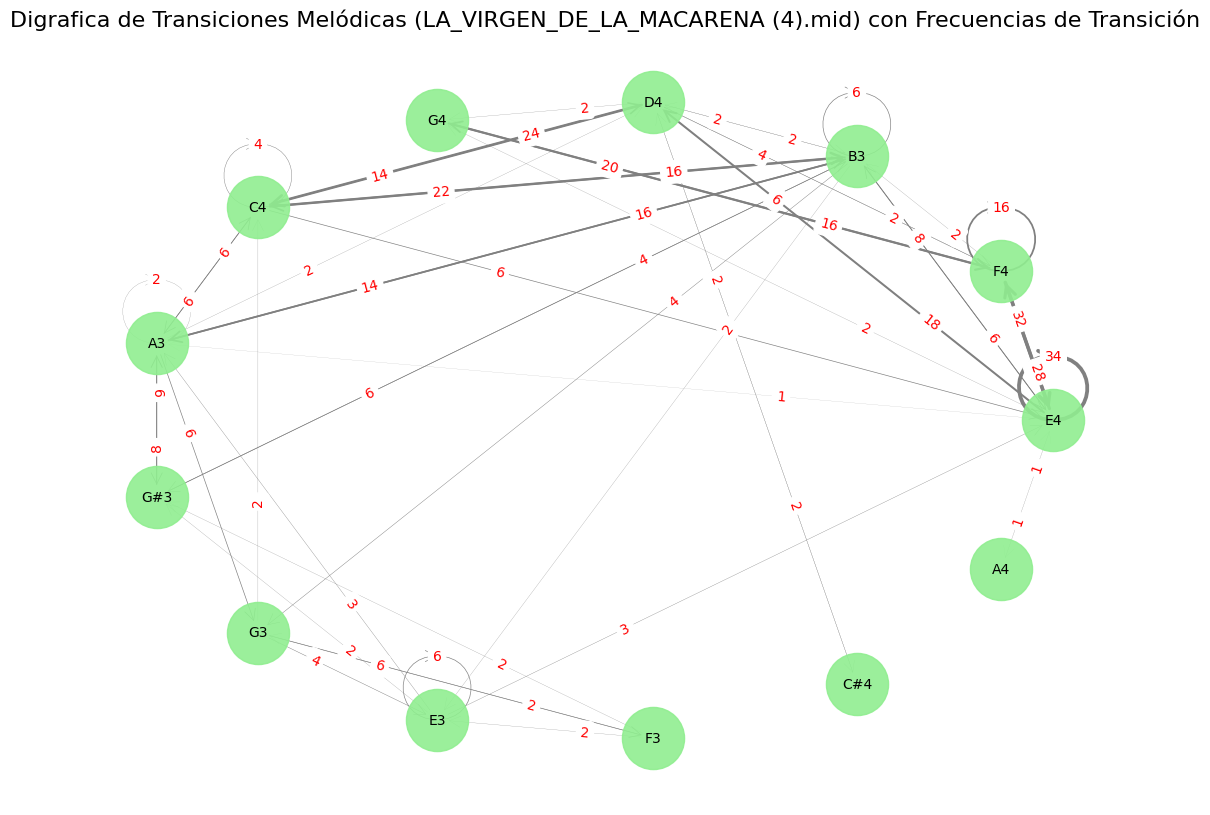

In [12]:
# === VISUALIZACIÓN DE  GRAFICA DE TRANSICIONES CON PESOS ===

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

try:
    notas_midi, G_simple = grafica_midi(nombre_archivo)

    # 2. Recalcular grafica para incluir los PESOS (frecuencia de transición)
    G = nx.DiGraph()
    transitions = defaultdict(int)

    for i in range(len(notas_midi) - 1):
        # Necesitamos la función nombre_nota_completo, asumida accesible o definida
        n1 = nombre_nota_completo(notas_midi[i])
        n2 = nombre_nota_completo(notas_midi[i+1])
        transitions[(n1, n2)] += 1

    # Agregar aristas con el peso (conteo de ocurrencias)
    for (n1, n2), count in transitions.items():
        G.add_edge(n1, n2, weight=count)

    print(f"Grafica cargada y ponderada desde el archivo: {nombre_archivo}")
    print(f"Nodos (Notas Únicas): {G.number_of_nodes()}")
    print(f"Aristas (Transiciones Ponderadas): {G.number_of_edges()}")

except NameError:
    print("ADVERTENCIA: No se pudo acceder a las variables necesarias. Usando una grafica de prueba con pesos.")
    # Usaremos una estructura simple de prueba con pesos para que el gráfico se dibuje
    G = nx.DiGraph()
    G.add_edge('C4', 'D4', weight=5)
    G.add_edge('D4', 'E4', weight=8)
    G.add_edge('E4', 'C4', weight=3)
    G.add_edge('E4', 'F4', weight=2)
    G.add_edge('C4', 'E4', weight=1)
    nombre_archivo = "PRUEBA"


# --- Configuración de la Visualización ---

plt.figure(figsize=(14, 10))

# 1. Definir la disposición de los nodos (layout)
pos = nx.circular_layout(G)

# 2. Obtener los pesos para la visualización
# Usaremos el peso para el grosor de la línea y el diccionario para las etiquetas.
weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_labels = nx.get_edge_attributes(G, 'weight')

# 3. Dibujar los nodos
nx.draw_networkx_nodes(G, pos,
                        node_color='#90EE90', # Verde claro
                        node_size=2000,
                        alpha=0.9)

# 4. Dibujar las aristas (flechas)
# El grosor de la línea será proporcional al peso (frecuencia)
nx.draw_networkx_edges(G, pos,
                        edgelist=G.edges(),
                        arrowstyle='->',
                        arrowsize=20,
                        edge_color='gray',
                        width=[w * 0.08 for w in weights]) # Escalamos el grosor de la línea

# 5. Dibujar las etiquetas (nombres de las notas)
nx.draw_networkx_labels(G, pos,
                        font_size=10,
                        font_family='sans-serif')

# 6. Dibujar las ETIQUETAS DE PESO en los arcos (¡NUEVO!)
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=edge_labels,
                             label_pos=0.3, # Posición del texto en el arco
                             font_color='red',
                             font_size=10)

# 7. Añadir título y mostrar el gráfico
plt.title(f'Digrafica de Transiciones Melódicas ({nombre_archivo}) con Frecuencias de Transición', fontsize=16)
plt.axis('off') # Ocultar los ejes de matplotlib
plt.show()